Step 1: Load the MNIST dataset

In [57]:
import torch as torch
import torchvision as torchvision
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import mnist_loader
from torchvision import transforms

batch_size_train = 64
batch_size_test = 1000


n_epochs = 3

def loadDataSets():
    global mnist_trainset

    mnist_trainset = datasets.MNIST(root='./data', train=True,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

    global train_loader
    train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

    mnist_testset = datasets.MNIST(root='./data', train=False,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

    global test_loader
    test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=True)

loadDataSets()



Plot a subset of the Dataset

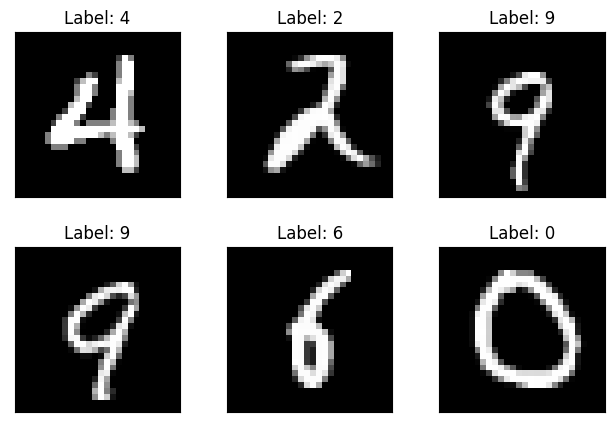

In [58]:
import matplotlib.pyplot as plt

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


Step 3: Construct Model

In [59]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from torch import nn
import torch.optim as optim

from torch.autograd import Variable



class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = nn.Linear(128, 256)
        self.linear_3 = nn.Linear(256, 10)

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.sigmoid(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.sigmoid(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)

        x = self.linear_2(x)
        x = self.sigmoid(x)
        x = self.linear_3(x)

        x2 = self.softmax(x)

        return x2, x


def initializeModel(learning_rate):
    global network
    network = CNN()
    print(network)

    global loss_fn
    loss_fn = nn.CrossEntropyLoss()

    global optimizer
    optimizer = torch.optim.Adam(params=network.parameters(), lr=learning_rate)



Step 4: Training the Model

In [60]:
import numpy
from sklearn.model_selection import train_test_split

crossEntropyLoss = nn.CrossEntropyLoss()

log_interval = 100

best_val_loss = 1

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):

    train_loss = list()
    val_loss = list()

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    network.to(device)

    network.train()
    total_train_loss = 0

    for epoch in range(num_epochs):

        for itr, (image, label) in enumerate(train_loader):


            optimizer.zero_grad()
            pred = network(image)[0]

            loss = crossEntropyLoss(pred, label)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            if itr  % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, itr * len(image), len(train_loader.dataset), 100. * itr / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './data/model.pth')
            torch.save(optimizer.state_dict(), './data/optimizer.pth')


Test Model

In [61]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)[0]
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

initializeModel(0.001)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


CNN(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=3136, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=256, bias=True)
  (linear_3): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


/Users/mstaylor/Documents/phd/courses/machineLearning/project/venv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.0999, Accuracy: 980/10000 (10%)

The model will be running on cpu device
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300617
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.302752
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.309408
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.321672
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.306833
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.302100
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.308223
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.304513
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.299071
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.299545

Test set: Avg. loss: -0.1033, Accuracy: 1135/10000 (11%)

The model will be running on cpu device
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.283752
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.295406
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.299057
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.920545
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.781633
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.690995
Train Epoch: 0 

Show Model Performance

/var/folders/7k/275tghp53d10sc13jdkx_xwm0000gp/T/ipykernel_8477/1926290494.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


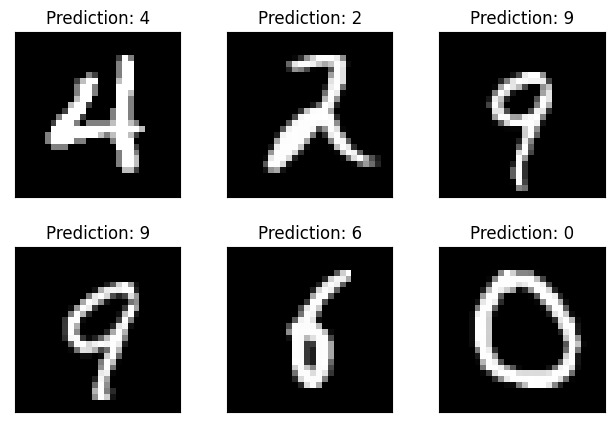

In [67]:

plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


with torch.no_grad():
  output = network(example_data)[0]

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
